In [1]:
library(tidyverse)
library(ape)
library(igraph)
library(nlme)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘igraph’


The following objects are masked from ‘package:ape’:

    edges, mst, ring


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:purrr’:

    compose, simplify


The following object is masked from ‘package:tidyr’:

    crossing


The 

### reading in the data

In [2]:
d <- read_csv("../data/data_cues.txt")


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  Glottocode = col_character(),
  Language = col_character(),
  Genus = col_character(),
  Case_Marking = col_double(),
  Tight_Semantics = col_double(),
  Rigid_Order = col_double(),
  Verb_Middle = col_double()
)



In [3]:
head(d)

Glottocode,Language,Genus,Case_Marking,Tight_Semantics,Rigid_Order,Verb_Middle
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
stan1318,Arabic,Semitic,0.036,0.218,0.655,0.391
bulg1262,Bulgarian,Slavic,0.028,0.144,0.782,0.966
croa1245,Croatian,Slavic,0.415,0.147,0.414,0.900
czec1258,Czech,Slavic,0.525,0.172,0.240,0.818
dani1285,Danish,Germanic,0.000,0.208,0.926,0.912
dutc1256,Dutch,Germanic,0.000,0.214,0.817,0.462


### preprocessing

I scaled the four variables to mean 0 and standard deviation 1.

The coding is:

- `x1`: Case_Marking
- `x2`: Tight_Semantics
- `x3`: Rigid_Order
- `x4`: Verb_middle



In [4]:

rescale <- function(x, e = 0.0001) {
    y = ifelse(x == 1, x - e, x)
    ifelse(y == 0, y + e, y)
}


In [5]:
logit <- function(x) {
    log(x / (1-x))
}

In [6]:
d %>%
    mutate(
        x1 = logit(rescale(Case_Marking)), 
        x2 = logit(rescale(Tight_Semantics)),
        x3 = logit(rescale(Rigid_Order)),
        x4 = logit(rescale(Verb_Middle))
    ) -> d
head(d)

Glottocode,Language,Genus,Case_Marking,Tight_Semantics,Rigid_Order,Verb_Middle,x1,x2,x3,x4
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
stan1318,Arabic,Semitic,0.036,0.218,0.655,0.391,-3.2875724,-1.277360,0.6410908,-0.4431107
bulg1262,Bulgarian,Slavic,0.028,0.144,0.782,0.966,-3.5471513,-1.782457,1.2773597,3.3468033
croa1245,Croatian,Slavic,0.415,0.147,0.414,0.900,-0.3433333,-1.758327,-0.3474538,2.1972246
czec1258,Czech,Slavic,0.525,0.172,0.240,0.818,0.1000835,-1.571519,-1.1526795,1.5028556
dani1285,Danish,Germanic,0.000,0.208,0.926,0.912,-9.2102404,-1.337023,2.5268091,2.3383032
dutc1256,Dutch,Germanic,0.000,0.214,0.817,0.462,-9.2102404,-1.300981,1.4961529,-0.1522937


In [7]:
d %>%
    select(x1, x2, x3, x4) %>%
    cor

,x1,x2,x3,x4
x1,1.0000000,0.2921834,-0.7871244,-0.4455840
x2,0.2921834,1.0000000,-0.2301989,-0.3685708
x3,-0.7871244,-0.2301989,1.0000000,0.3038085
x4,-0.4455840,-0.3685708,0.3038085,1.0000000


### reading in the phylogenetic tree

In [8]:
trees <- ape::read.tree("../data/posterior.tree")
tree <- phangorn::maxCladeCred(trees)

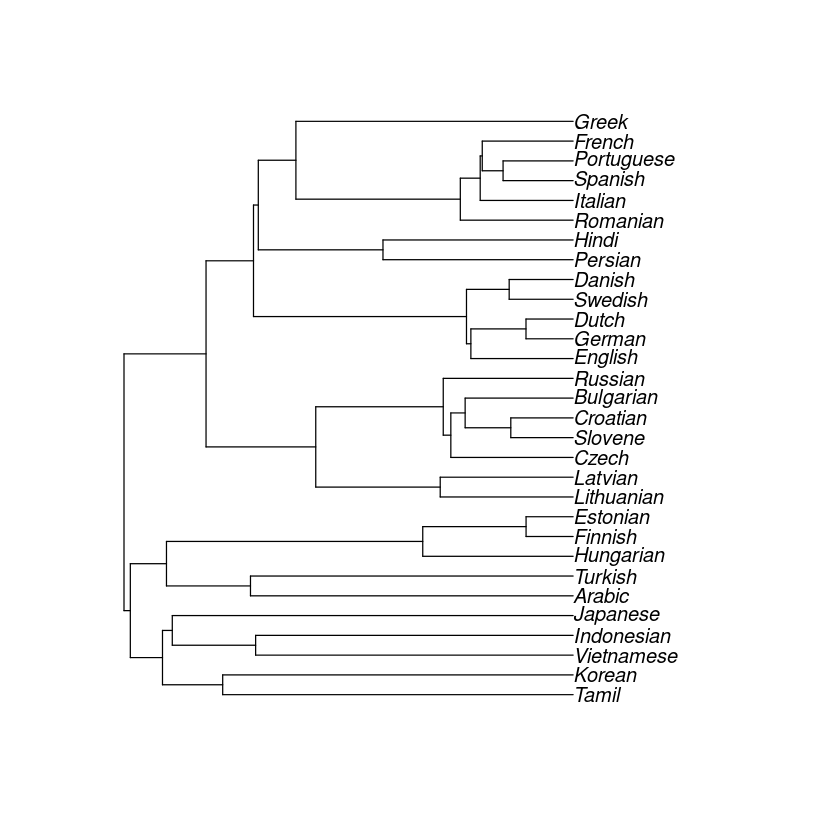

In [9]:
plot(tree)

## Testing for (conditional) independence

I test for stochastic independence via a phylogenetic linear regression.

To test whether $$x \perp \!\!\! \perp y|z,$$

I run a linear regression 

$$
x \sim y + z.
$$

If the slope for $y$ is not significantly different from 0, independence is given.

The phylogenetic regression is performed using the function `tree_phylm` from the library `sensiPhy`. It expects are regular dataframe.

In [10]:
d <- as.data.frame(d)
rownames(d) <- d$Language
head(d)

,Glottocode,Language,Genus,Case_Marking,Tight_Semantics,Rigid_Order,Verb_Middle,x1,x2,x3,x4
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Arabic,stan1318,Arabic,Semitic,0.036,0.218,0.655,0.391,-3.2875724,-1.277360,0.6410908,-0.4431107
Bulgarian,bulg1262,Bulgarian,Slavic,0.028,0.144,0.782,0.966,-3.5471513,-1.782457,1.2773597,3.3468033
Croatian,croa1245,Croatian,Slavic,0.415,0.147,0.414,0.900,-0.3433333,-1.758327,-0.3474538,2.1972246
Czech,czec1258,Czech,Slavic,0.525,0.172,0.240,0.818,0.1000835,-1.571519,-1.1526795,1.5028556
Danish,dani1285,Danish,Germanic,0.000,0.208,0.926,0.912,-9.2102404,-1.337023,2.5268091,2.3383032
Dutch,dutc1256,Dutch,Germanic,0.000,0.214,0.817,0.462,-9.2102404,-1.300981,1.4961529,-0.1522937


In [11]:
d <- d[tree$tip.label,]

### Running the PC algorithm by hand

starting with a fully connected graph

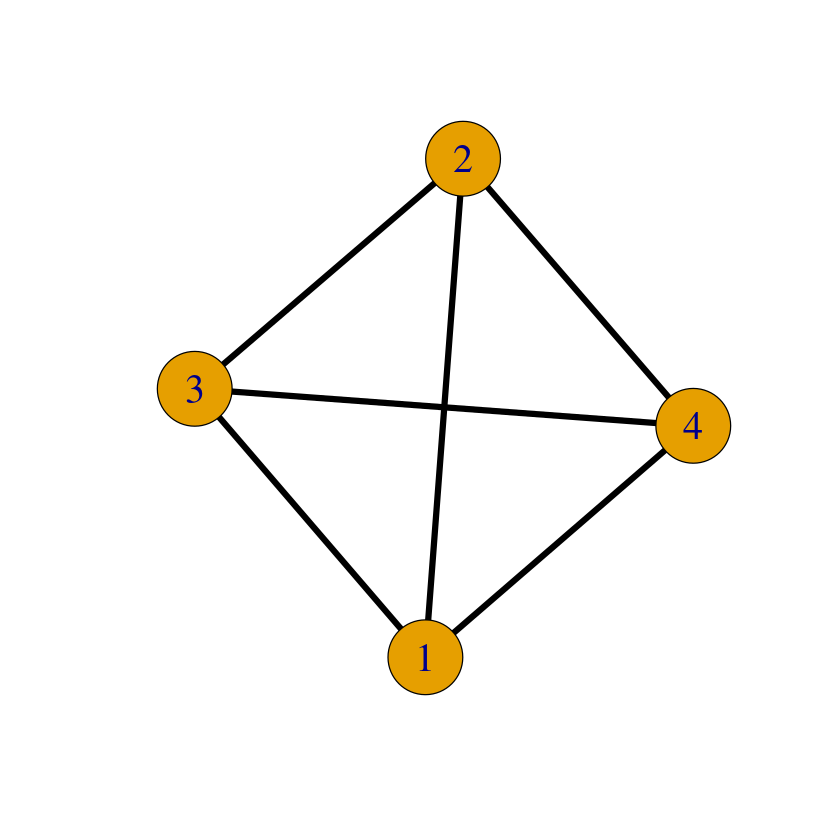

In [12]:
g <- make_full_graph(4)
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

checking unconditional independence between `x1` and `x2`.

I do three regressions:

- ordinary regression
- regression with a phylogenetic term and Brownian motion model
- regression with a phylogenetic term and Brownian motion model after transforming the phylogeny by fitting Pagel's $\lambda$.

The best model will be picked according to AIC.

In [13]:
md1_1 <- lm(x1 ~ x2, data=d)
AIC(md1_1)

[1] 164.6004

In [14]:
md1_2 <- gls(x1 ~ x2, correlation=corBrownian(phy=tree), data=d)
AIC(md1_2)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 157.8237

In [15]:
md1_3 <- gls(x1 ~ x2, correlation=corPagel(1, phy=tree), data=d)
AIC(md1_3)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 153.1663

The last model comes out best:

In [16]:
AIC(md1_1, md1_2, md1_3)
summary(md1_3)

Warning message in AIC.default(md1_1, md1_2, md1_3):
“models are not all fitted to the same number of observations”


,df,AIC
,<dbl>,<dbl>
md1_1,3,164.6004
md1_2,3,157.8237
md1_3,4,153.1663


Generalized least squares fit by REML
  Model: x1 ~ x2 
  Data: d 
       AIC      BIC    logLik
  153.1663 158.4951 -72.58313

Correlation Structure: corPagel
 Formula: ~1 
 Parameter estimate(s):
   lambda 
0.7158808 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) 0.0282695  2.481032 0.0113943  0.9910
x2          1.7269458  1.365425 1.2647676  0.2164

 Correlation: 
   (Intr)
x2 0.897 

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.0038386 -0.5680208  0.1571005  0.6896944  1.3496419 

Residual standard error: 3.489197 
Degrees of freedom: 30 total; 28 residual

clearly no significant correlation.

In [17]:
E(g)

+ 6/6 edges from d719da2:
[1] 1--2 1--3 1--4 2--3 2--4 3--4

In [18]:
g <- delete_edges(g, 1)

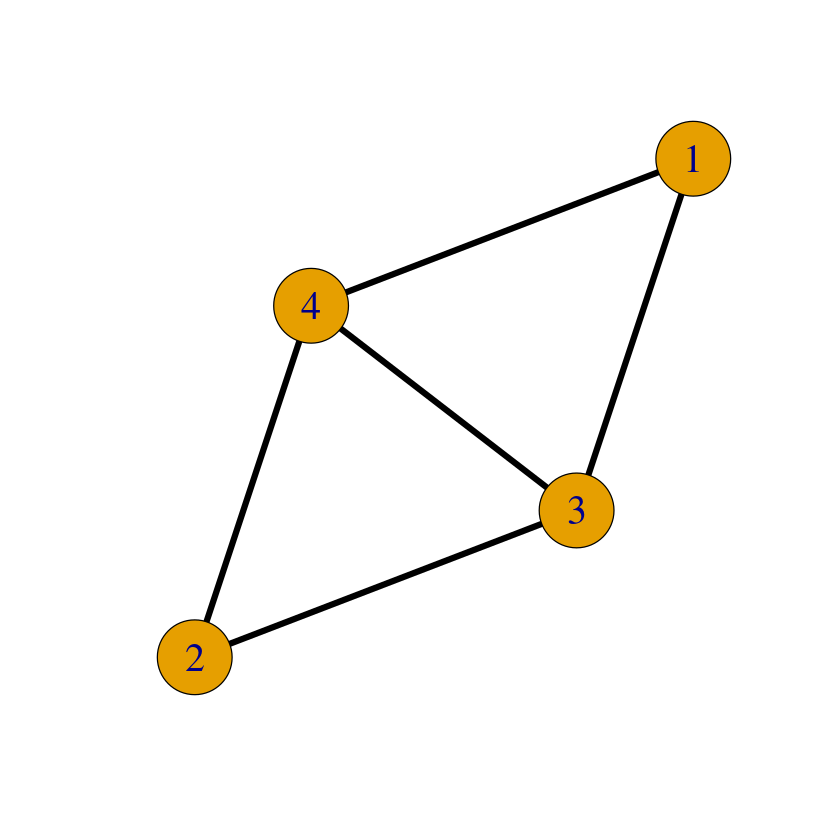

In [19]:
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

independence between `x1` and `x3`

In [20]:
md2_1 <- lm(x1 ~ x3, data=d)
AIC(md2_1)

[1] 138.2843

In [21]:
md2_2 <- gls(x1 ~ x3, correlation=corBrownian(phy=tree), data=d)
AIC(md2_2)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 145.1585

In [22]:
md2_3 <- gls(x1 ~ x3, correlation=corPagel(1, phy=tree), data=d)
AIC(md2_3)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 138.533

In [23]:
summary(md2_3)

Generalized least squares fit by REML
  Model: x1 ~ x3 
  Data: d 
      AIC      BIC    logLik
  138.533 143.8618 -65.26651

Correlation Structure: corPagel
 Formula: ~1 
 Parameter estimate(s):
   lambda 
0.5609534 

Coefficients:
                Value Std.Error   t-value p-value
(Intercept) -1.763844 0.7452386 -2.366817  0.0251
x3          -1.515019 0.2839099 -5.336266  0.0000

 Correlation: 
   (Intr)
x3 -0.263

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-2.1352296 -0.5032007  0.1527512  0.4843233  1.5876854 

Residual standard error: 2.425827 
Degrees of freedom: 30 total; 28 residual

`x1` and `x3` are not independent.

continuing with `x1` vs. `x4`:

In [24]:
md3_1 <- lm(x1 ~ x4, data=d)
AIC(md3_1)

[1] 160.6377

In [25]:
md3_2 <- gls(x1 ~ x4, correlation=corBrownian(phy=tree), data=d)
AIC(md3_2)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 155.4299

In [26]:
md3_3 <- gls(x1 ~ x4, correlation=corPagel(1, phy=tree), data=d)
AIC(md3_3)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 149.8697

In [27]:
summary(md3_3)

Generalized least squares fit by REML
  Model: x1 ~ x4 
  Data: d 
       AIC      BIC    logLik
  149.8697 155.1985 -70.93484

Correlation Structure: corPagel
 Formula: ~1 
 Parameter estimate(s):
   lambda 
0.7389621 

Coefficients:
                 Value Std.Error   t-value p-value
(Intercept) -3.1535178 0.9851605 -3.201019  0.0034
x4          -0.4871956 0.1499063 -3.250000  0.0030

 Correlation: 
   (Intr)
x4 0.116 

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.9868606 -0.5484048  0.1985649  1.1973265  1.7023135 

Residual standard error: 3.085732 
Degrees of freedom: 30 total; 28 residual

Clearly significant. The graph is still

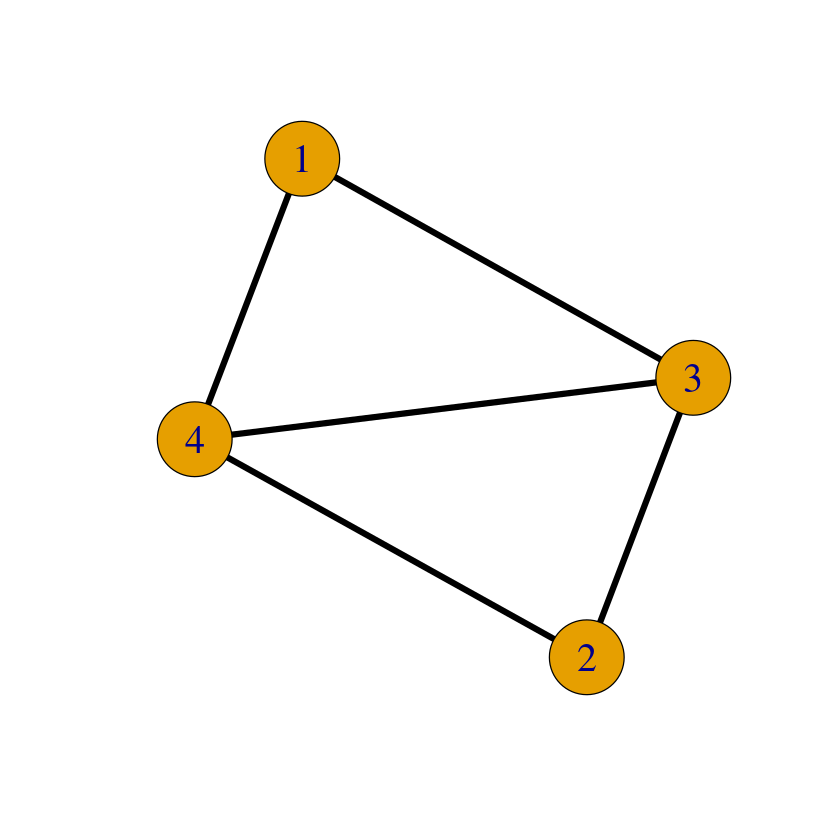

In [28]:
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

independence of `x2` and `x3`:

In [29]:
md4_1 <- lm(x2 ~ x3, data=d)
AIC(md4_1)

[1] 35.70394

In [30]:
md4_2 <- gls(x2 ~ x3, correlation=corBrownian(phy=tree), data=d)
AIC(md4_2)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 41.01748

In [31]:
md4_3 <- gls(x2 ~ x3, correlation=corPagel(1, phy=tree), data=d)
AIC(md4_3)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 43.00061

In [32]:
summary(md4_1)


Call:
lm(formula = x2 ~ x3, data = d)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.1745 -0.1950  0.0422  0.2555  0.7716 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.57843    0.08227 -19.186   <2e-16 ***
x3          -0.05720    0.04570  -1.252    0.221    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4109 on 28 degrees of freedom
Multiple R-squared:  0.05299,	Adjusted R-squared:  0.01917 
F-statistic: 1.567 on 1 and 28 DF,  p-value: 0.221


clearly not significant

In [33]:
E(g)

+ 5/5 edges from 1f33560:
[1] 1--3 1--4 2--3 2--4 3--4

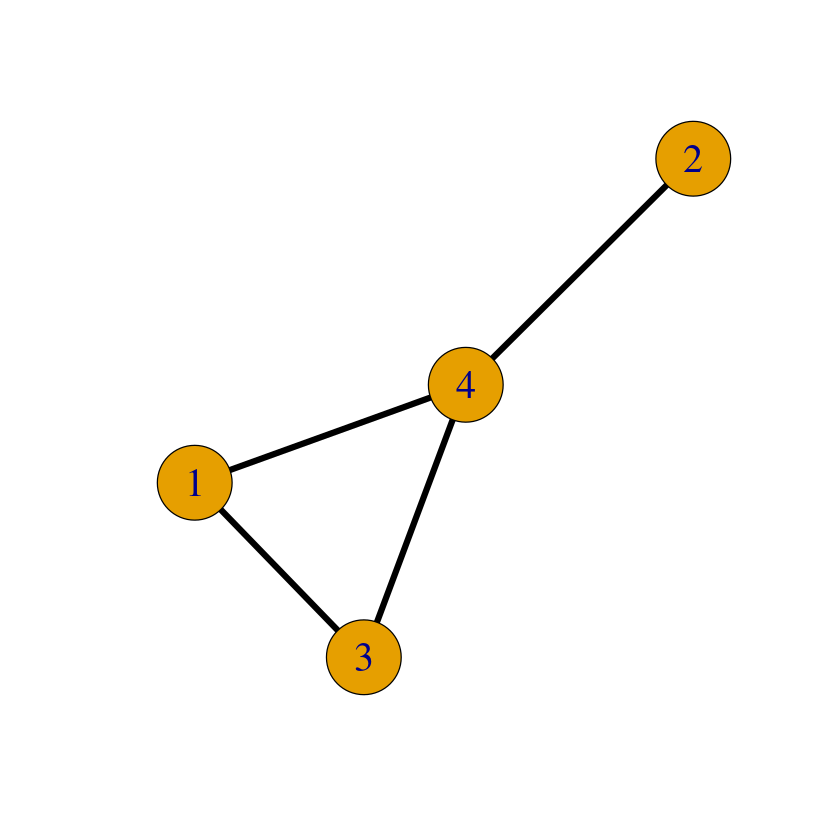

In [34]:
g <- delete_edges(g, 3)
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [36]:
md5_1 <- lm(x2 ~ x4, data=d)
AIC(md5_1)

[1] 32.95728

In [37]:
md5_2 <- gls(x2 ~ x4, correlation=corBrownian(phy=tree), data=d)
AIC(md5_2)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 39.15205

In [38]:
md5_3 <- gls(x2 ~ x4, correlation=corPagel(1, phy=tree), data=d)
AIC(md5_3)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 41.08228

In [39]:
summary(md5_1)


Call:
lm(formula = x2 ~ x4, data = d)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.32043 -0.12378  0.04403  0.22796  0.67099 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.59139    0.07301 -21.796   <2e-16 ***
x4          -0.03812    0.01817  -2.098   0.0451 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3925 on 28 degrees of freedom
Multiple R-squared:  0.1358,	Adjusted R-squared:  0.105 
F-statistic: 4.402 on 1 and 28 DF,  p-value: 0.04505


significant, if barely

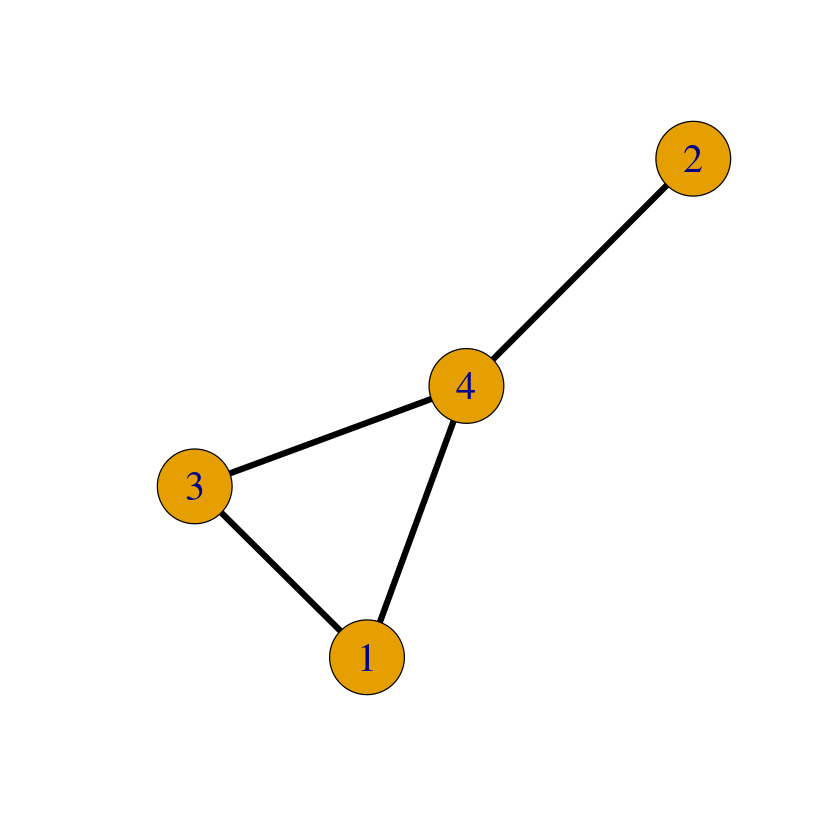

In [40]:

plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [41]:
md6_1 <- lm(x3 ~ x4, data=d)
AIC(md6_1)

[1] 117.9756

In [42]:
md6_2 <- gls(x3 ~ x4, correlation=corBrownian(phy=tree), data=d)
AIC(md6_2)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 104.2617

In [43]:
md6_3 <- gls(x3 ~ x4, correlation=corPagel(1, phy=tree), data=d)
AIC(md6_3)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 105.5852

In [44]:
summary(md6_2)

Generalized least squares fit by REML
  Model: x3 ~ x4 
  Data: d 
       AIC      BIC    logLik
  104.2617 108.2583 -49.13084

Correlation Structure: corBrownian
 Formula: ~1 
 Parameter estimate(s):
numeric(0)

Coefficients:
                Value Std.Error  t-value p-value
(Intercept) 0.8834967 0.5855953 1.508716  0.1426
x4          0.2107762 0.0783907 2.688792  0.0119

 Correlation: 
   (Intr)
x4 0.133 

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.73997943 -0.83961130 -0.09785085  0.51122566  1.67011765 

Residual standard error: 1.690975 
Degrees of freedom: 30 total; 28 residual

 significant

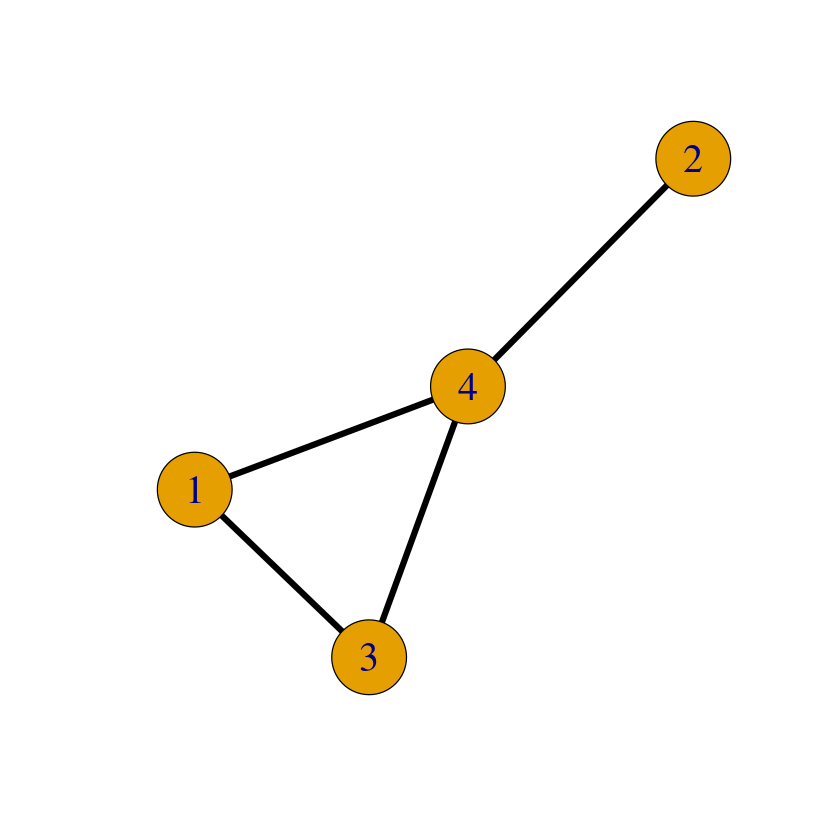

In [45]:
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

Now we continue with conditional independence.

In [46]:
md2_1 <- lm(x1 ~ x3 + x4, data=d)
AIC(md2_1)

[1] 136.3323

In [47]:
md2_2 <- gls(x1 ~ x3 + x4, correlation=corBrownian(phy=tree), data=d)
AIC(md2_2)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 146.985

In [48]:
md2_3 <- gls(x1 ~ x3 + x4, correlation=corPagel(1, phy=tree), data=d)
AIC(md2_3)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 138.259

In [49]:
summary(md2_1)


Call:
lm(formula = x1 ~ x3 + x4, data = d)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.1108 -0.5771  0.5967  1.5429  2.4234 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.8029     0.4342  -4.152 0.000296 ***
x3           -1.5559     0.2528  -6.155 1.41e-06 ***
x4           -0.2052     0.1052  -1.950 0.061656 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.165 on 27 degrees of freedom
Multiple R-squared:  0.6665,	Adjusted R-squared:  0.6418 
F-statistic: 26.98 on 2 and 27 DF,  p-value: 3.643e-07


The correlation between $x_1$ and $x_4$ is explained the fact that they are both connected to $x_3$.

In [50]:
E(g)

+ 4/4 edges from c1f07cc:
[1] 1--3 1--4 2--4 3--4

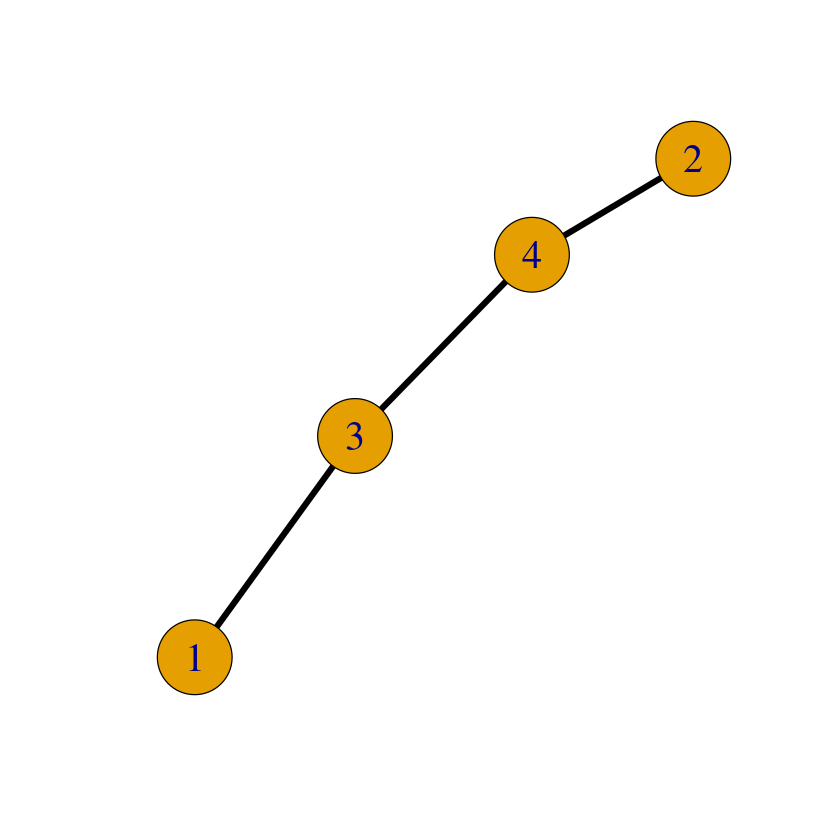

In [51]:
g <- delete_edges(g, 2)
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [52]:
md3_1 <- lm(x1 ~ x4 + x3, data=d)
AIC(md3_1)

[1] 136.3323

In [53]:
md3_2 <- gls(x1 ~ x4 + x3, correlation=corBrownian(phy=tree), data=d)
AIC(md3_2)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 146.985

In [54]:
md3_3 <- gls(x1 ~ x4 + x3, correlation=corPagel(1, phy=tree), data=d)
AIC(md3_3)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 138.259

In [55]:
summary(md3_1)


Call:
lm(formula = x1 ~ x4 + x3, data = d)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.1108 -0.5771  0.5967  1.5429  2.4234 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -1.8029     0.4342  -4.152 0.000296 ***
x4           -0.2052     0.1052  -1.950 0.061656 .  
x3           -1.5559     0.2528  -6.155 1.41e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.165 on 27 degrees of freedom
Multiple R-squared:  0.6665,	Adjusted R-squared:  0.6418 
F-statistic: 26.98 on 2 and 27 DF,  p-value: 3.643e-07


In [56]:
md4_1 <- lm(x2 ~ x3 + x4, data=d)
AIC(md4_1)

[1] 34.4179

In [57]:
md4_2 <- gls(x2 ~ x3 + x4, correlation=corBrownian(phy=tree), data=d)
AIC(md4_2)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 44.91998

In [58]:
md4_3 <- gls(x2 ~ x3 + x4, correlation=corPagel(1, phy=tree), data=d)
AIC(md4_3)

Warning message in Initialize.corPhyl(X[[i]], ...):
“No covariate specified, species will be taken as ordered in the data frame. To avoid this message, specify a covariate containing the species names with the 'form' argument.”


[1] 46.73144

In [59]:
summary(md4_1)


Call:
lm(formula = x2 ~ x3 + x4, data = d)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.30825 -0.11920  0.05207  0.21900  0.66147 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.57062    0.07944 -19.772   <2e-16 ***
x3          -0.03236    0.04624  -0.700   0.4900    
x4          -0.03403    0.01925  -1.768   0.0884 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3962 on 27 degrees of freedom
Multiple R-squared:  0.1512,	Adjusted R-squared:  0.08837 
F-statistic: 2.406 on 2 and 27 DF,  p-value: 0.1093


The final graph, according to this method, is

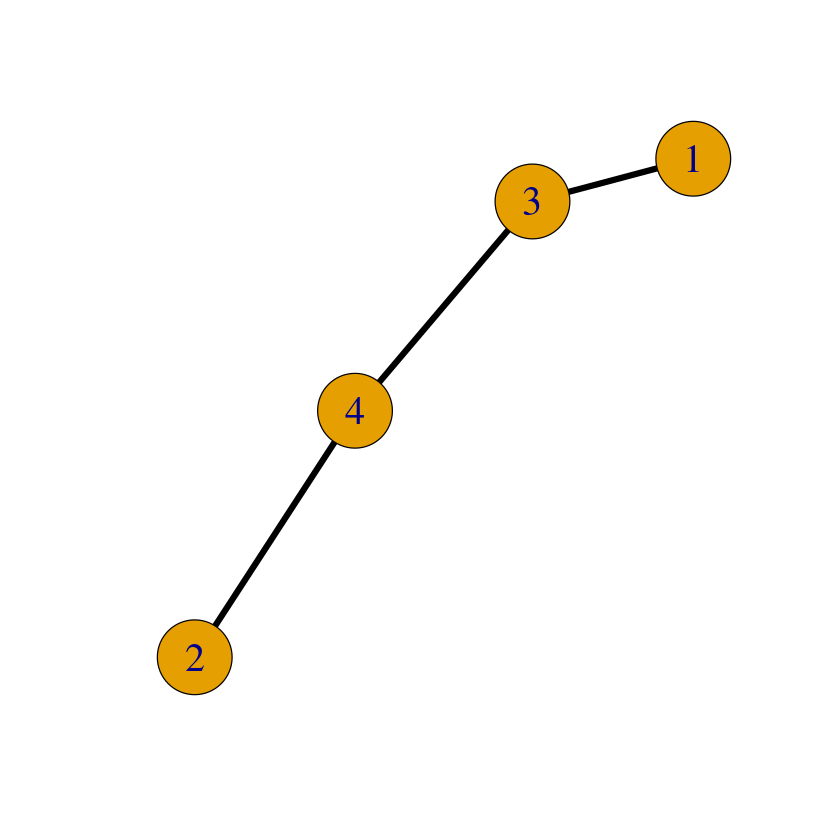

In [60]:
plot(g, vertex.size=30, edge.width = 5, edge.color = "black", vertex.label.cex=2)

In [89]:
x1 <- d$x1
names(x1) <- d$Language

In [90]:
x2 <- d$x2
names(x2) <- d$Language

In [91]:
x3 <- d$x3
names(x3) <- d$Language

In [92]:
x4 <- d$x4
names(x4) <- d$Language

In [96]:
(picDF <- data.frame(
    x1 = pic(x1, tree),
    x2 = pic(x2, tree),
    x3 = pic(x3, tree),
    x4 = pic(x4, tree)
    ))

,x1,x2,x3,x4
,<dbl>,<dbl>,<dbl>,<dbl>
31,-0.5392679,-0.20071300,1.26400995,-7.5669513
32,-5.6696469,0.27097079,3.07892866,-5.3849018
33,6.9038587,0.49773291,-4.12517175,-14.1451180
34,-2.8742231,-1.13499901,-4.36209282,3.0356448
35,-13.1280133,-1.06509376,2.96753784,20.3511886
36,0.0000000,0.97644724,-3.13999397,-3.6719902
37,-4.2782058,-0.99500225,2.21260800,-4.3399299
38,-2.3080859,2.07415043,0.04836185,3.8675997
39,2.1407600,0.61755878,-3.50611608,-3.0318865


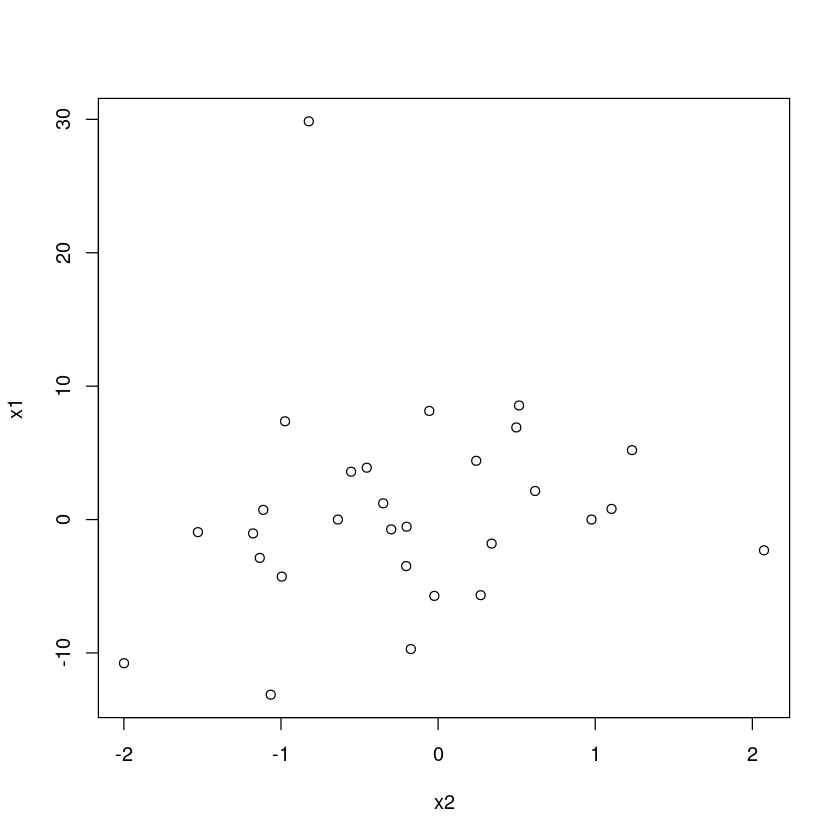

In [98]:
plot(x1 ~ x2, data=picDF)

In [99]:
summary(lm(x1 ~ x2-1, data=picDF))


Call:
lm(formula = x1 ~ x2 - 1, data = picDF)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.1682  -3.3074   0.0212   4.0921  30.5931 

Coefficients:
   Estimate Std. Error t value Pr(>|t|)
x2   0.9012     1.5743   0.572    0.572

Residual standard error: 7.774 on 28 degrees of freedom
Multiple R-squared:  0.01157,	Adjusted R-squared:  -0.02373 
F-statistic: 0.3277 on 1 and 28 DF,  p-value: 0.5716


In [100]:
summary(lm(x1 ~ x3-1, data=picDF))


Call:
lm(formula = x1 ~ x3 - 1, data = picDF)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.9798 -3.5705 -0.7564  1.3288 23.8092 

Coefficients:
   Estimate Std. Error t value Pr(>|t|)    
x3  -1.6289     0.3594  -4.532 9.95e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.938 on 28 degrees of freedom
Multiple R-squared:  0.4232,	Adjusted R-squared:  0.4026 
F-statistic: 20.54 on 1 and 28 DF,  p-value: 9.948e-05


In [101]:
summary(lm(x1 ~ x4-1, data=picDF))


Call:
lm(formula = x1 ~ x4 - 1, data = picDF)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.5573 -2.4983 -1.2464  0.6481 29.6802 

Coefficients:
   Estimate Std. Error t value Pr(>|t|)  
x4  -0.5362     0.1955  -2.743   0.0105 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.941 on 28 degrees of freedom
Multiple R-squared:  0.2118,	Adjusted R-squared:  0.1837 
F-statistic: 7.526 on 1 and 28 DF,  p-value: 0.01049


In [102]:
summary(lm(x2 ~ x3-1, data=picDF))


Call:
lm(formula = x2 ~ x3 - 1, data = picDF)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7882 -0.9462 -0.2415  0.3325  2.0761 

Coefficients:
   Estimate Std. Error t value Pr(>|t|)
x3 -0.04006    0.05597  -0.716     0.48

Residual standard error: 0.9247 on 28 degrees of freedom
Multiple R-squared:  0.01797,	Adjusted R-squared:  -0.0171 
F-statistic: 0.5124 on 1 and 28 DF,  p-value: 0.48


In [103]:
summary(lm(x2 ~ x4-1, data=picDF))


Call:
lm(formula = x2 ~ x4 - 1, data = picDF)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.5610 -0.8390 -0.2118  0.1756  2.2681 

Coefficients:
   Estimate Std. Error t value Pr(>|t|)  
x4 -0.05016    0.02451  -2.047   0.0502 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8703 on 28 degrees of freedom
Multiple R-squared:  0.1301,	Adjusted R-squared:  0.09906 
F-statistic: 4.189 on 1 and 28 DF,  p-value: 0.05019


In [104]:
summary(lm(x3 ~ x4-1, data=picDF))


Call:
lm(formula = x3 ~ x4 - 1, data = picDF)

Residuals:
   Min     1Q Median     3Q    Max 
-5.167 -2.867 -1.144  1.607  4.214 

Coefficients:
   Estimate Std. Error t value Pr(>|t|)  
x4  0.21078    0.07839   2.689   0.0119 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.784 on 28 degrees of freedom
Multiple R-squared:  0.2052,	Adjusted R-squared:  0.1768 
F-statistic:  7.23 on 1 and 28 DF,  p-value: 0.01194
